In [17]:
import os
import time
import tensorflow as tf

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


#helper functions
def compute_num_params():
    #counting the total number of parameters in our network
    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        #print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)

def conv2d(x, W):
    h_conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return h_conv

def max_pool_2x2(x):
    h_max = tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
    return h_max

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
result_dir= 'mnist_model_summaries'
max_iter  = 20000

# start a session
tf.reset_default_graph()
sess = tf.InteractiveSession()
start_time = time.time() # start timing

x         = tf.placeholder(tf.float32, shape=[None, 784])
y_        = tf.placeholder(tf.float32, [None, 10])

x_image   = tf.reshape(x, [-1, 28, 28, 1])

#convolutional layer 1
with tf.name_scope('conv1'):
    nh1       = 32 #number of channels out
    nh_pre    = 1  #number of channels in
    W1        = tf.get_variable('W1', shape = [5, 5, 1, nh1],
                                initializer = tf.contrib.layers.xavier_initializer(),
                                dtype=tf.float32)
    b1        = tf.get_variable('b1', shape = [nh1],
                                initializer = tf.contrib.layers.xavier_initializer(), 
                                dtype=tf.float32)     
    h_conv1   = conv2d(x_image,W1) + b1
    h_bnorm1  = tf.contrib.layers.batch_norm(h_conv1, epsilon=1e-5, scope='bn1')
    h_act1    = tf.nn.relu(h_bnorm1)
    h_pool1   = max_pool_2x2(h_act1)
    print(h_pool1.shape)

#convolutional layer 2
with tf.name_scope('conv2'):
    nh2       = 64 #number of channels out
    nh_pre    = nh1  #number of channels in
    W2        = tf.get_variable('W2', shape = (5, 5, nh1, nh2), 
                                initializer = tf.contrib.layers.xavier_initializer(),
                                dtype=tf.float32)
    b2        = tf.get_variable('b2', shape = [nh2],
                                initializer = tf.contrib.layers.xavier_initializer(),
                                dtype=tf.float32)
      
    h_conv2   = conv2d(h_pool1,W2) + b2
    h_bnorm2  = tf.contrib.layers.batch_norm(h_conv2, epsilon=1e-5, scope='bn2')
    h_act2    = tf.nn.relu(h_bnorm2)
    h_pool2   = max_pool_2x2(h_act2)
    print(h_pool2.shape)

#fully connected layer1
with tf.name_scope('fc1'):
    nh3 = 1024
    W_fc1 = tf.get_variable('W_fc1', shape = [7 * 7 * nh2, nh3],
                                initializer = tf.contrib.layers.xavier_initializer(),
                                dtype=tf.float32)
    b_fc1 = tf.get_variable('b_fc1', shape = [nh3],
                                initializer = tf.contrib.layers.xavier_initializer(), 
                                dtype=tf.float32)  
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * nh2])
    #h_bnorm  = tf.contrib.layers.batch_norm(h_pool2_flat, epsilon=1e-3, scope='bn')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    print(h_fc1.shape)

#dropout layer
with tf.name_scope('dropout'):
    keep_prob  = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    print(h_fc1_drop.shape)
    
#fully connected layer2
with tf.name_scope('fc2'):
    W_fc2 = tf.get_variable('W_fc2', shape = [nh3, 10],
                                initializer = tf.contrib.layers.xavier_initializer(),
                                dtype=tf.float32)
    b_fc2 = tf.get_variable('b_fc2', shape = [10],
                                initializer = tf.contrib.layers.xavier_initializer(), 
                                dtype=tf.float32) 
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    print(y_conv.shape)
    
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

# Create a saver for writing training checkpoints.
saver = tf.train.Saver()

#with tf.Session() as sess:
sess.run(tf.global_variables_initializer())
for i in range(max_iter):
    batch = mnist.train.next_batch(50)
    if i % 200 == 0:
        train_accuracy = accuracy.eval(feed_dict = {x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict = {x: batch[0], y_: batch[1], keep_prob: .5})
    
saver.save(sess, 'model.ckpt')
print("Model saved in file: %s" % save_path)

print('test accuracy %g' % accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
# Save the variables to disk.


stop_time = time.time()
print('The training takes %f second to finish'%(stop_time - start_time))
compute_num_params()

(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 1024)
(?, 1024)
(?, 10)
step 0, training accuracy 0.22
step 200, training accuracy 0.96
step 400, training accuracy 0.98
step 600, training accuracy 1
step 800, training accuracy 1
step 1000, training accuracy 0.98
step 1200, training accuracy 1
step 1400, training accuracy 0.98
step 1600, training accuracy 0.98
step 1800, training accuracy 0.96
step 2000, training accuracy 1
step 2200, training accuracy 1
step 2400, training accuracy 1
step 2600, training accuracy 1
step 2800, training accuracy 1
step 3000, training accuracy 1
step 3200, training accuracy 1
step 3400, training accuracy 1
step 3600, training accuracy 1
step 3800, training accuracy 1
step 4000, training accuracy 1
step 4200, training accuracy 1
step 4400, training accuracy 1
step 4600, training accuracy 1
step 4800, training accuracy 1
step 5000, training accuracy 1
step 5200, training accuracy 1
step 5400, training accuracy 0.98
step 5600, training accuracy 0.98
step 5800, training acc

true accuracy:  1.0
range(4, 14) range(7, 17)
predicted label: [0]
accuracy: 1.0



range(4, 14) range(10, 20)
predicted label: [0]
accuracy: 1.0



range(4, 14) range(13, 23)
predicted label: [6]
accuracy: 0.0



range(7, 17) range(7, 17)
predicted label: [0]
accuracy: 1.0



range(7, 17) range(10, 20)
predicted label: [0]
accuracy: 1.0



range(7, 17) range(13, 23)
predicted label: [6]
accuracy: 0.0



range(10, 20) range(7, 17)
predicted label: [0]
accuracy: 1.0



range(10, 20) range(10, 20)
predicted label: [0]
accuracy: 1.0



range(10, 20) range(13, 23)
predicted label: [0]
accuracy: 1.0



range(13, 23) range(7, 17)
predicted label: [7]
accuracy: 0.0



range(13, 23) range(10, 20)
predicted label: [0]
accuracy: 1.0



range(13, 23) range(13, 23)
predicted label: [0]
accuracy: 1.0



12


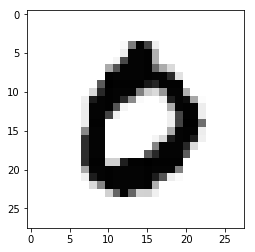

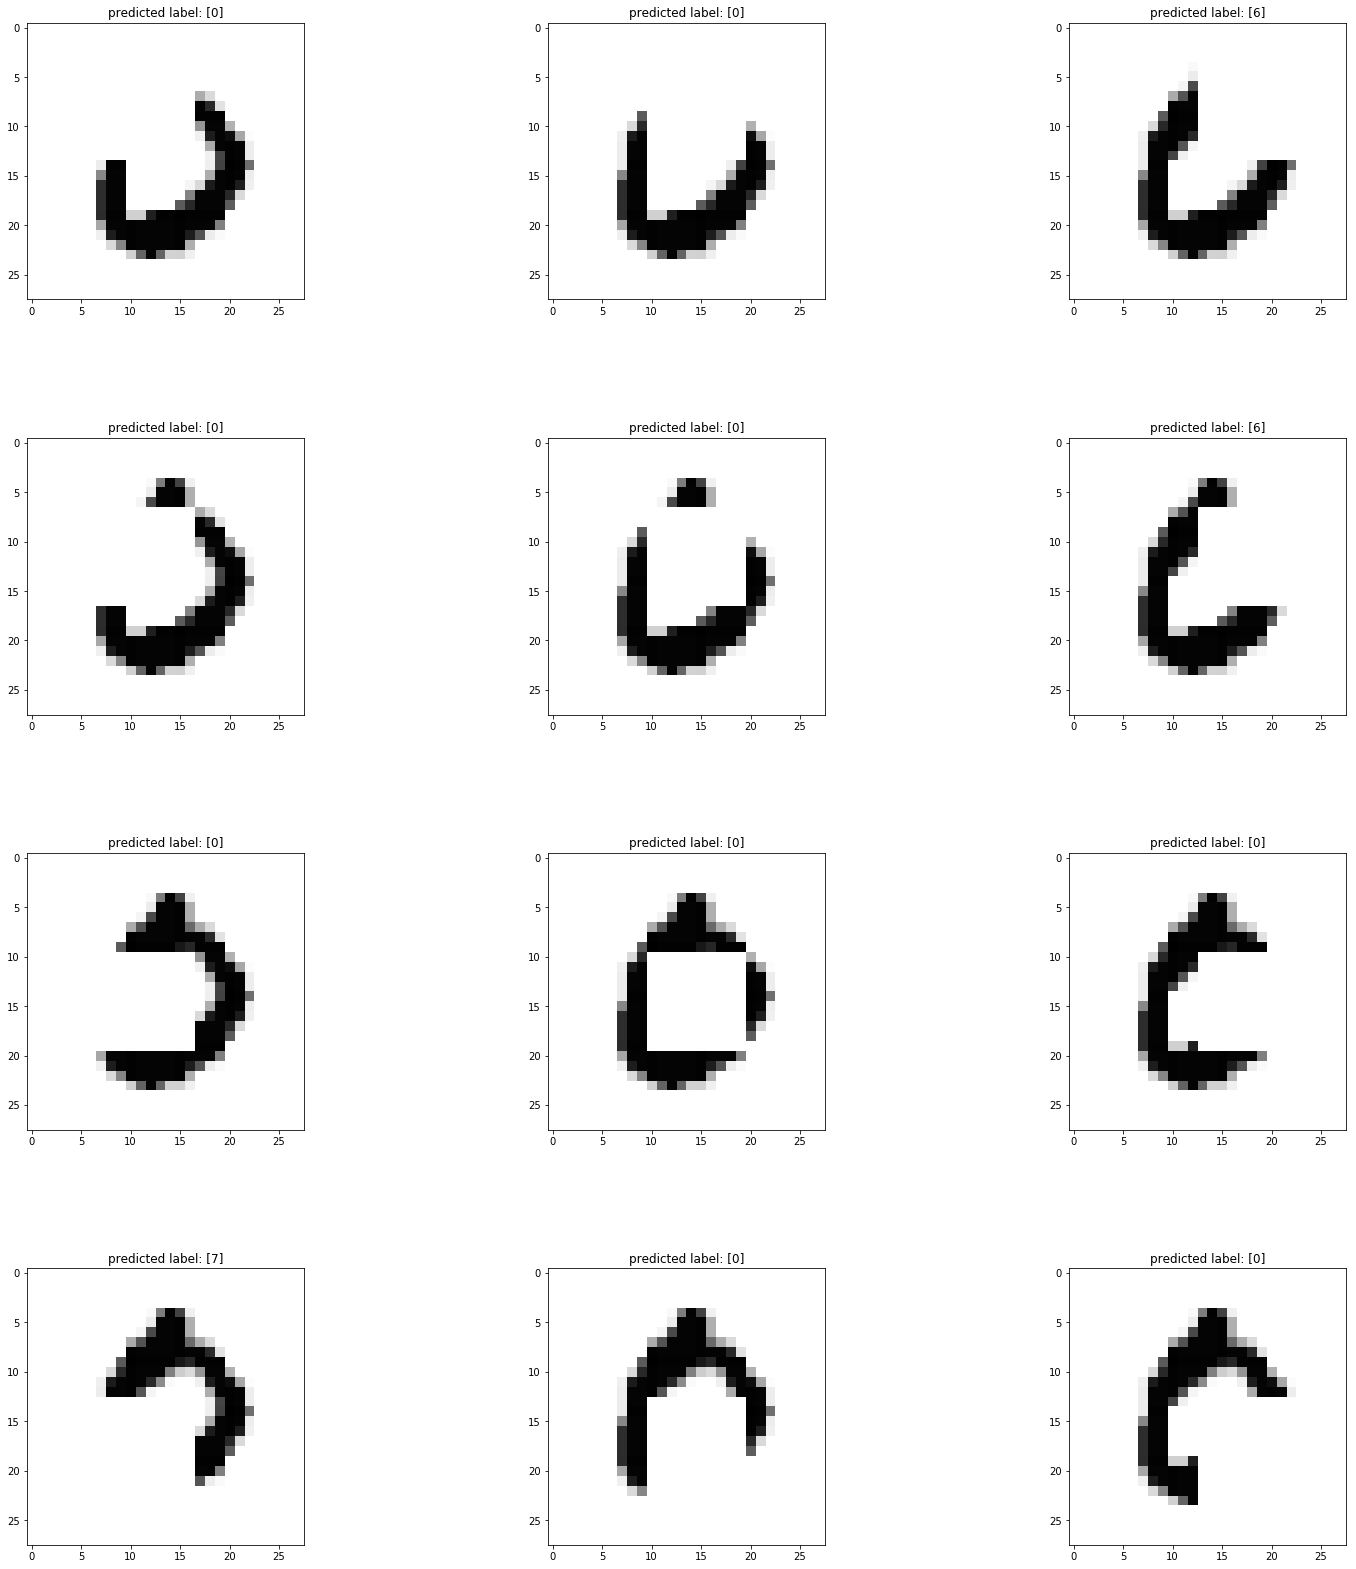

In [32]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

sample_image = mnist.test.images[3]
sample_label = mnist.test.labels[3]
#print(sample_label)
sample_image = sample_image.reshape((1,784))
sample_label = sample_label.reshape((1,10))
true_label   = np.argmax(sample_label, axis=1)

print("true accuracy: ", sess.run(accuracy, feed_dict={x:sample_image, y_:sample_label, keep_prob: 1.0}))


# we aim to occlude only the nonzero portion of the image which contains essential information
img = sample_image.reshape([28, 28])
plt.imshow(img, cmap='Greys')
#print(img.nonzero())
max_r = np.max(img.nonzero(), axis = 1)[0]
max_c = np.max(img.nonzero(), axis = 1)[1]
min_r = np.min(img.nonzero(), axis = 1)[0]
min_c = np.min(img.nonzero(), axis = 1)[1]

#dimensions of our rectanglur moving occlusion patch
w = 10
h = 10

#sizes of our strides
strides2 = strides1 = 3

# range objects for performing iterations in for loops
iter_rows    = range(min_r,int(np.array([max_r-w+strides1, 28]).min()), strides1)
iter_columns = range(min_c,int(np.array([max_c-h+strides2,28]).min()), strides2)

#total number of possible occlusions in each dimension 
num_rows     = len(iter_rows)
num_columns   = len(iter_columns) 



# plotting figures of occluded image
fig, axs = plt.subplots(num_rows,num_columns, figsize=(28, 28))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
index = 0
#axs[index].imshow(sample_image, cmap='Greys')
#axs[index].set_title("true label "+ str(true_label))
#index +=1
for i in iter_rows:
    for j in iter_columns:
        occluded_img = img.copy()
        
        if i == iter_rows[-1]:
            occluded_img[i:28, j:j+h] = 0
            
        
        elif j==iter_columns[-1]:
            occluded_img[i:i+h, j:28] = 0
        
        else:
            occluded_img[i:i+w, j:j+h] = 0
        
        #plt.figure()
        print(range(i,i+w), range(j,j+w))
        occluded_img_vec = occluded_img.reshape((1,784))
        fig = plt.figure()
        
        perd, acc = sess.run([y_conv,accuracy], feed_dict={x:occluded_img_vec, y_:sample_label, keep_prob: 1.0})
        probs = sess.run((tf.nn.softmax(perd)))
        perd_label = np.argmax(probs, axis=1)
        print("predicted label:", perd_label)
        print("accuracy:", acc)
        print(2*'\n')
        
        
        axs[index].imshow(occluded_img, cmap='Greys')
        axs[index].set_title("predicted label: "+ str(perd_label))
        index +=1
print(index)
